<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/MNIST/MNIST_%EC%B5%9C%EC%A2%85_%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In [1]:
#!/usr/bin/env python3

import os
import math
import argparse

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, Sequence

from copy import deepcopy

### for notebook users
%matplotlib inline

## Preprocessing & Inspecting

### Defining Dataloader
tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성

In [2]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [4]:
target_size = 10

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2 ** 8 - 1)
X_test = X_test.astype("float32") / (2 ** 8 - 1)

y_train = to_categorical(y_train, target_size)
y_test = to_categorical(y_test, target_size)

In [5]:
train_batch_size = 2 ** 7
test_batch_size = 2 ** 7

train_loader = Dataloader(X_train, y_train, train_batch_size, shuffle=True)
test_loader = Dataloader(X_test, y_test, test_batch_size, shuffle=False)

### Dataset Inspecting

In [6]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


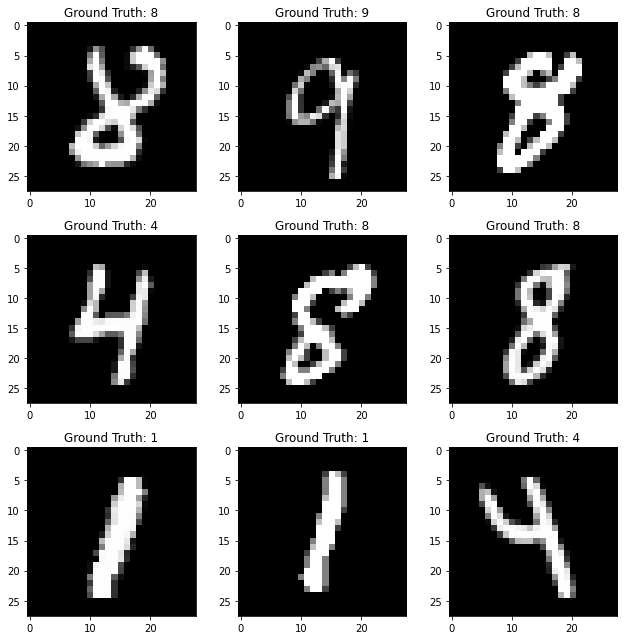

In [7]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Modeling

In [8]:
def CNN(act, initial, dropout, use_bn):
    
    if act == "ReLU" or act == "relu":
        activation = "relu"
    elif act == "sigmoid":
        activation = "sigmoid"
    elif act == "tanh":
         activation = "tanh"
    elif act == "softmax":
        activation = "softmax"
    else:
        raise ValueError("Not a valid activation function.")
    
    if initial == "Xavier" or initial == "glorot":
        initializer = "glorot_uniform"
    elif initial == "he":
        initializer = "he_uniform"
    else:
        raise ValueError("Not a valid initializer.")
    
    model=Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same",
                            activation=activation, input_shape=(28, 28, 1)))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same",
                            activation=activation))

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                            activation=activation))

    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(dropout))

    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation="softmax"))
    print(model.summary())
    
    return model

## Experiment

In [9]:
def experiment(args):
    
    model = CNN(act=args.act, initial=args.initializer,
                dropout=args.dropout, use_bn=args.use_bn)
    
    if args.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    elif args.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=args.lr)
    elif args.optimizer == "Adam" or args.optimizer == "ADAM":
        optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    else:
        raise ValueError("Not a valid Optimizer.")
    
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    hist = model.fit(X_train, y_train, batch_size=args.train_batch_size,
                 epochs=args.epoch, validation_split=0.2, verbose=1,
                 callbacks=callback_list)
    
    return hist, model

## Hyperparametrization

In [10]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

### Model
# args.model_code = "VGG16"    # 실행할 모델 이름 (미구현)
args.in_dim = 1 * 28 * 28      # 파일 크기
# args.hidden_dim = 100        # MLP의 Hidden Dimension (미구현)
args.out_dim = 10              # 0부터 9까지, 총 10가지
args.act = "ReLU"              # Activation Function(ReLU, sigmoid, tanh, softmax 구현)
#args.kernel_size = 3          # filter의 size

### Regulization
args.l2 = 5e-5                 # l2 정규화 alpha 값
args.use_bn = True             # Batch Normalization 사용 여부
args.dropout = 0.2             # dropout 비율
args.initializer = "Xavier"    # Initializer 설정(Xavier, he 구현)

### Training & Test
args.optimizer = "RMSprop"     # Optimizer 설정(SGD, RMSprop, Adam 구현)
args.lr = 5e-5                 # Learning Rate
args.epoch = 30                # Epoch 횟수
args.train_batch_size = 2**7   # Training Batch Size
args.test_batch_size = 2**7    # Test Batch Size

### Callback Function
args.monitor = "val_accuracy"  # loss, val_loss, accuracy, val_accuracy
args.patience = 3              # callback function의 patience 값 (0 이상의 정수)
args.min_delta = 0             # patience count의 기준치

### Experiment Variable

name_var1 = ""
name_var2 = ""

list_var1 = []
list_var2 = []

### Defining Callback Function

In [11]:
scheduler = lambda epoch: 0.001 - args.lr + 0.02 * (0.5**(1 + epoch))

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

earlystop = callbacks.EarlyStopping(monitor=args.monitor,
                                    min_delta=args.min_delta,
                                    patience=args.patience,verbose=1,
                                    mode="auto", baseline=None,
                                    restore_best_weights=True)

callback_list = [lr_scheduler, earlystop]

## Evaluation

In [12]:
model_list = []
hist_list = []

count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        
        print(args)
        
        hist, model = experiment(deepcopy(args))
        
        model_list.append(model)
        hist_list.append(hist)

### Visualization for Train & Validation

In [13]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [14]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
              .format(hist_list[count].history["loss"][-1],
                     hist_list[count].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
              .format(hist_list[count].history["val_loss"][-1],
                     hist_list[count].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[count])
        plt.show()
        
        count +=1

## Test

In [15]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        score = model_list[count].evaluate(X_test, y_test, verbose=0)
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}\n".format(score[1]))
        
        count += 1

## FINAL RESULT

In [16]:
def multi_train(times):

    hist_list = []
    model_list = []

    for i in range(times):

        hist, model = experiment(deepcopy(args))

        hist_list.append(hist)
        model_list.append(model)

    return hist_list, model_list



def multi_train_result(hist_list, model_list, times):

    for i in range(times):

        print("Train #{0}".format(1 + i))
            
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
            .format(hist_list[i].history["loss"][-1],
                    hist_list[i].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
            .format(hist_list[i].history["val_loss"][-1],
                    hist_list[i].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[i])



def multi_test(model_list, times):
    
    mean_test_loss = 0
    mean_test_acc = 0

    for i in range(times):

        score = model_list[i].evaluate(X_test, y_test, verbose=0)
        print("Test #{0}".format(1 + i))
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}".format(score[1]))

        mean_test_loss += score[0]
        mean_test_acc += score[1]
    
    mean_test_loss /= times
    mean_test_acc /= times

    if times == 1:
        print("\nAfter learning 1 time, we obtained")
        print("Test Loss: {}".format(mean_test_loss))
        print("Test Accuracy: {}".format(mean_test_acc))
    
    else:
        print("\nAfter learning {} times, we obtained".format(times))
        print("Expectation of Test Loss: {}".format(mean_test_loss))
        print("Expectation of Test Accuracy: {}".format(mean_test_acc))

    return mean_test_loss, mean_test_acc



def report(times):

    hist_list, model_list = multi_train(times)
    print("=================================================================")
    multi_train_result(hist_list, model_list, times)
    print("=================================================================")
    mean_test_loss, mean_test_acc = multi_test(model_list, times)

    return [hist_list, model_list, mean_test_loss, mean_test_acc, times]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

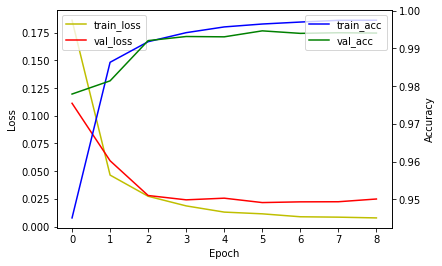

Train #2
Train Loss: 0.005572820547968149, 	Train Accuracy: 0.9982291460037231
Validation Loss: 0.023669585585594177, 	Validation Accuracy: 0.9940000176429749


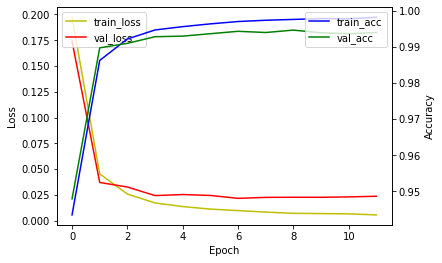

Train #3
Train Loss: 0.006750475615262985, 	Train Accuracy: 0.9979583621025085
Validation Loss: 0.02360135316848755, 	Validation Accuracy: 0.9944999814033508


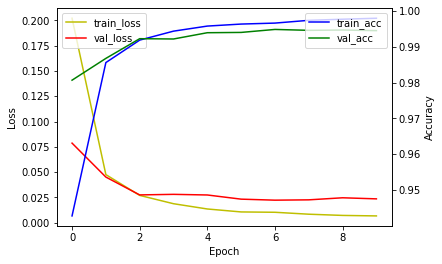

Train #4
Train Loss: 0.004382820334285498, 	Train Accuracy: 0.9985208511352539
Validation Loss: 0.026009414345026016, 	Validation Accuracy: 0.9939166903495789


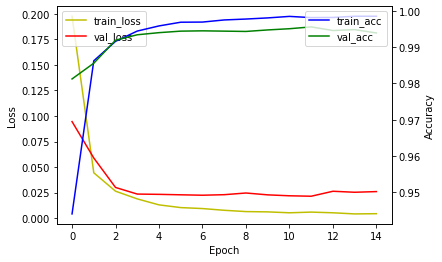

Train #5
Train Loss: 0.007630737964063883, 	Train Accuracy: 0.9975000023841858
Validation Loss: 0.02187662571668625, 	Validation Accuracy: 0.9945833086967468


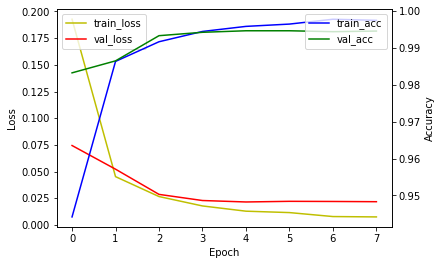

Train #6
Train Loss: 0.004740824922919273, 	Train Accuracy: 0.9984791874885559
Validation Loss: 0.02456718683242798, 	Validation Accuracy: 0.9945833086967468


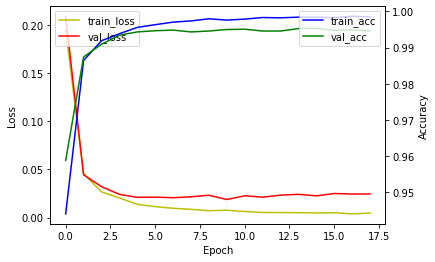

Train #7
Train Loss: 0.006222752388566732, 	Train Accuracy: 0.9980416893959045
Validation Loss: 0.022281471639871597, 	Validation Accuracy: 0.9946666955947876


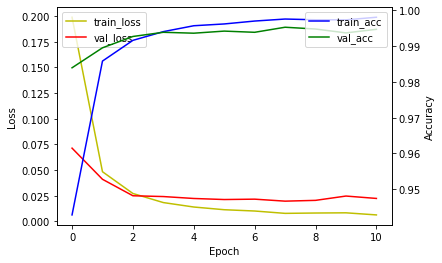

Train #8
Train Loss: 0.009213590994477272, 	Train Accuracy: 0.9973124861717224
Validation Loss: 0.02472137287259102, 	Validation Accuracy: 0.9932500123977661


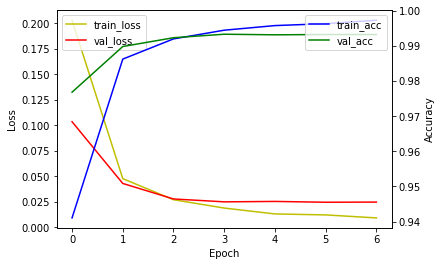

Train #9
Train Loss: 0.005428024102002382, 	Train Accuracy: 0.9982291460037231
Validation Loss: 0.02524491585791111, 	Validation Accuracy: 0.9945833086967468


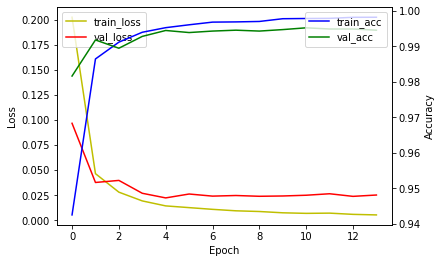

Train #10
Train Loss: 0.006211795378476381, 	Train Accuracy: 0.9980416893959045
Validation Loss: 0.021625084802508354, 	Validation Accuracy: 0.9949166774749756


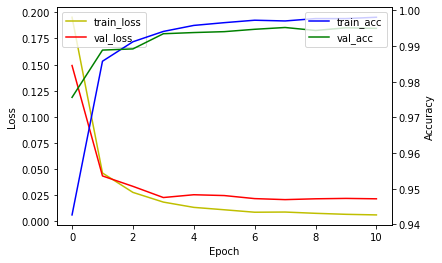

Test #1
Test Loss: 0.013960405252873898
Test Accuracy: 0.995199978351593
Test #2
Test Loss: 0.01706080697476864
Test Accuracy: 0.9957000017166138
Test #3
Test Loss: 0.01319602970033884
Test Accuracy: 0.9957000017166138
Test #4
Test Loss: 0.01632201485335827
Test Accuracy: 0.9958999752998352
Test #5
Test Loss: 0.015182510018348694
Test Accuracy: 0.9961000084877014
Test #6
Test Loss: 0.016262423247098923
Test Accuracy: 0.9957000017166138
Test #7
Test Loss: 0.014778648503124714
Test Accuracy: 0.9954000115394592
Test #8
Test Loss: 0.01939171366393566
Test Accuracy: 0.9937000274658203
Test #9
Test Loss: 0.01651318557560444
Test Accuracy: 0.9948999881744385
Test #10
Test Loss: 0.01468973234295845
Test Accuracy: 0.995199978351593

After learning 10 times, we obtained
Expectation of Test Loss: 0.015735747013241052
Expectation of Test Accuracy: 0.9953499972820282


In [17]:
result_list = report(10)

### Review

In Test #1, 48 data were not matched correctly.


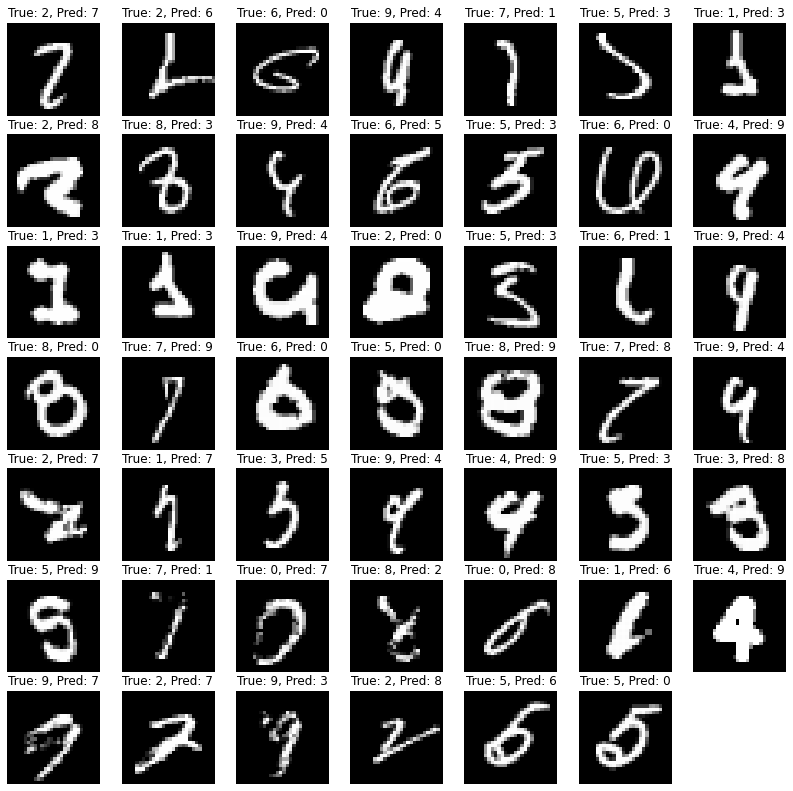

In Test #2, 43 data were not matched correctly.


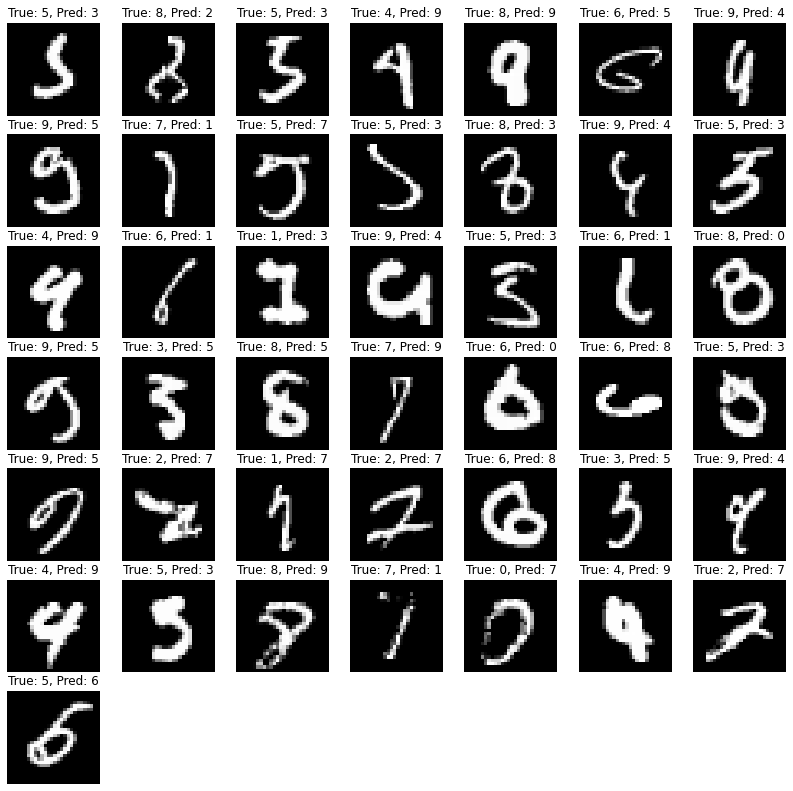

In Test #3, 43 data were not matched correctly.


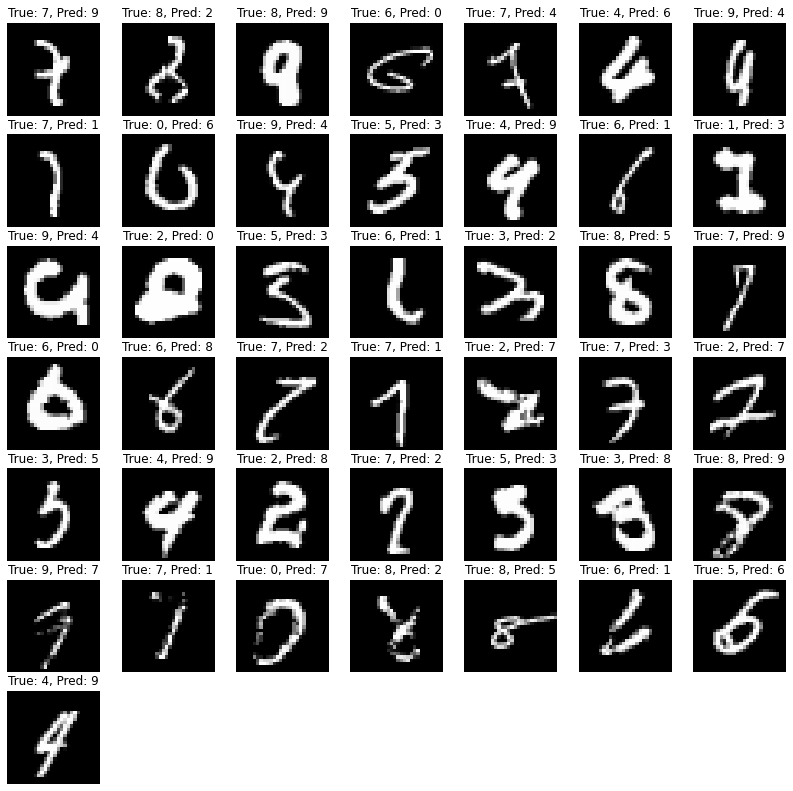

In Test #4, 41 data were not matched correctly.


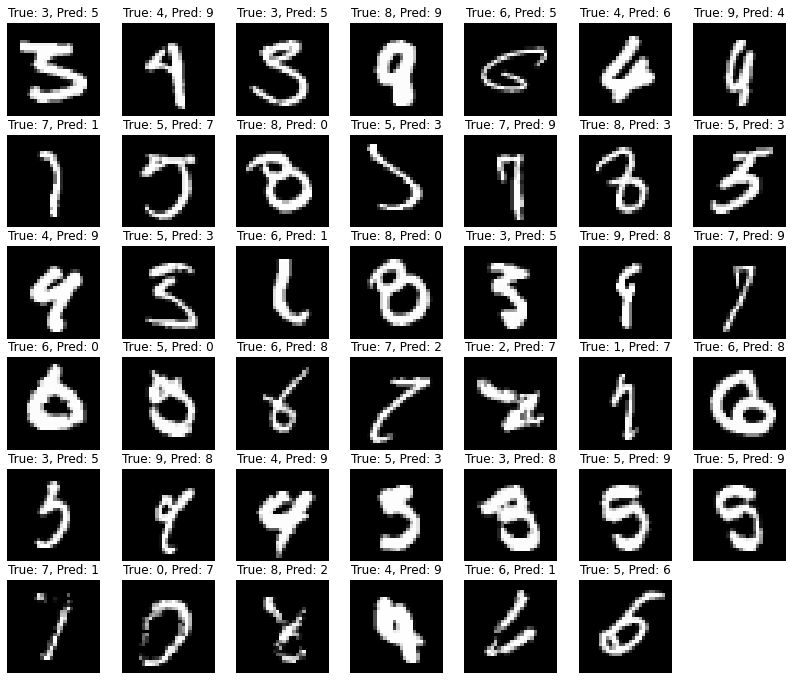

In Test #5, 39 data were not matched correctly.


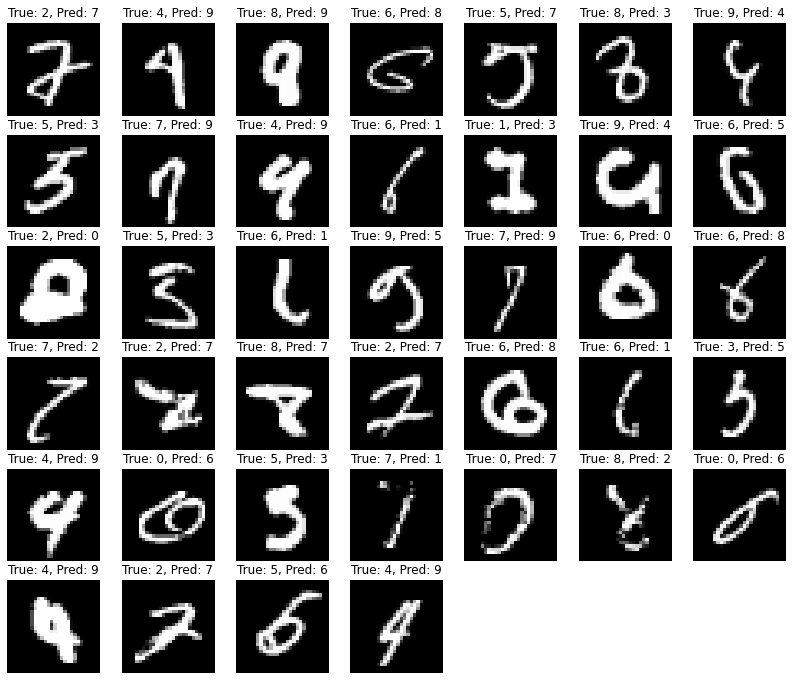

In Test #6, 43 data were not matched correctly.


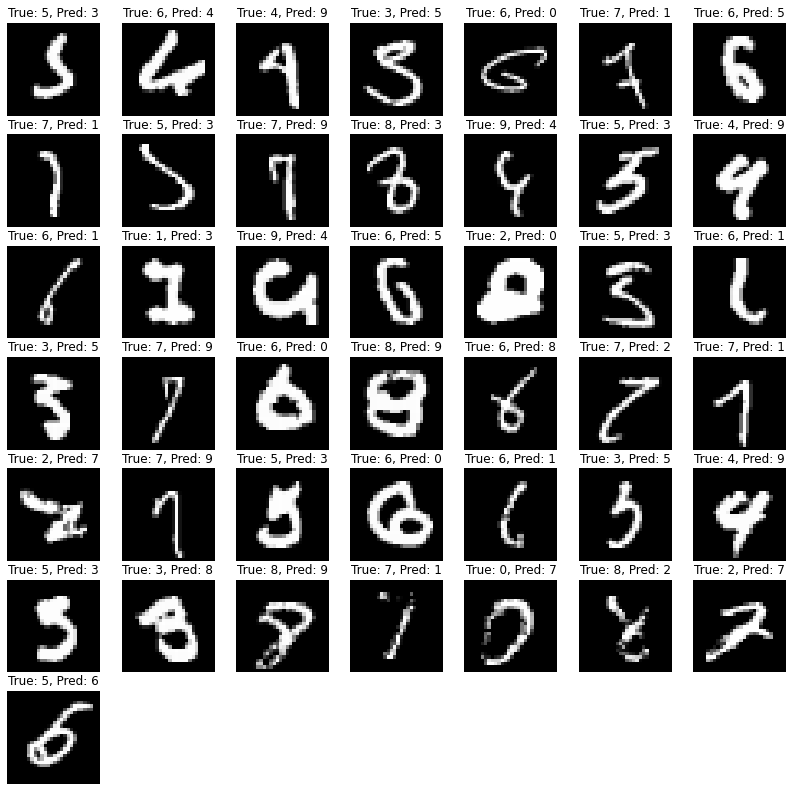

In Test #7, 46 data were not matched correctly.


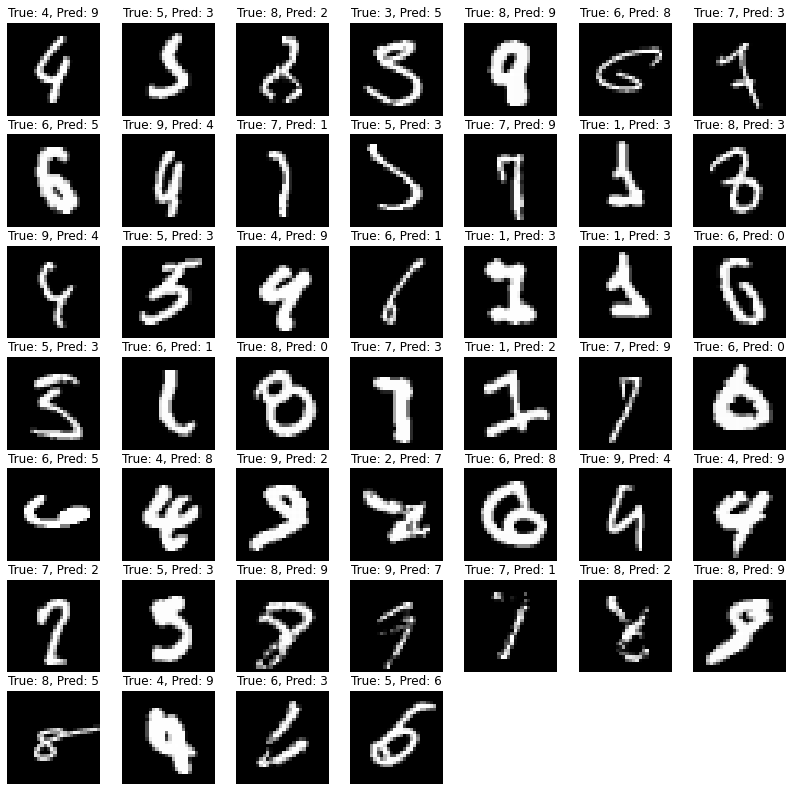

In Test #8, 63 data were not matched correctly.


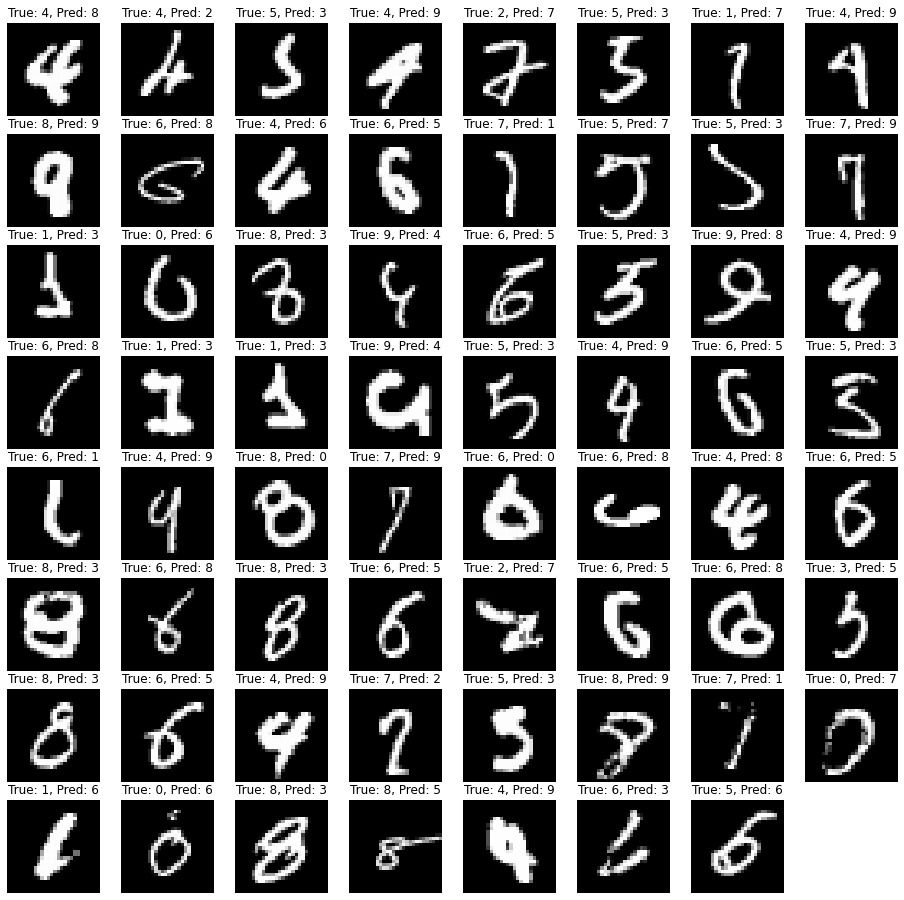

In Test #9, 51 data were not matched correctly.


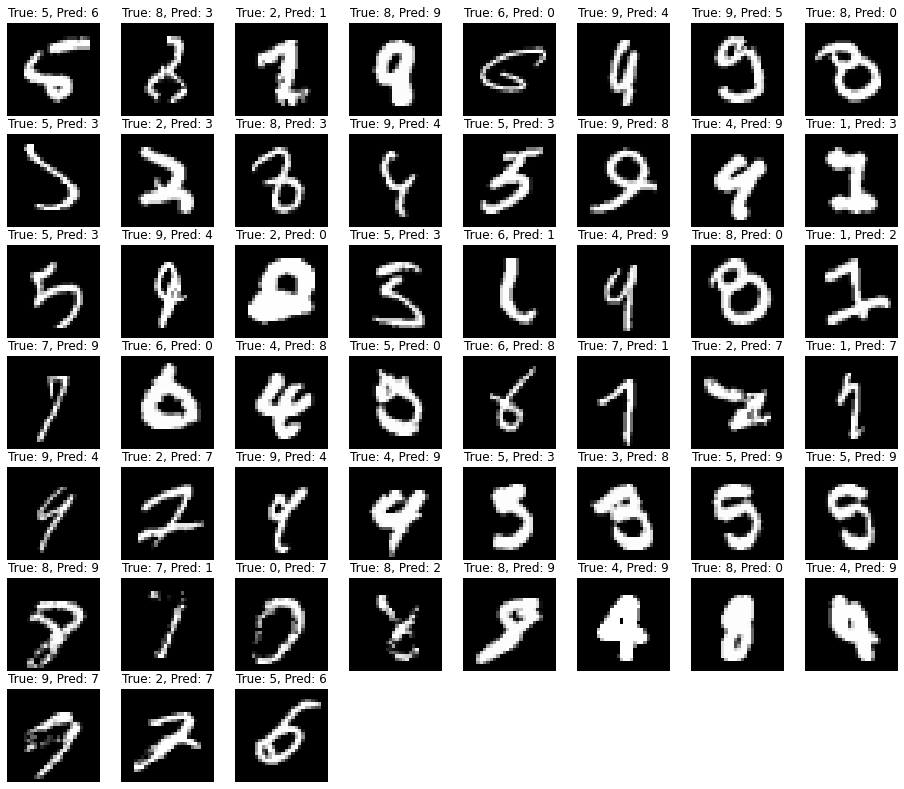

In Test #10, 48 data were not matched correctly.


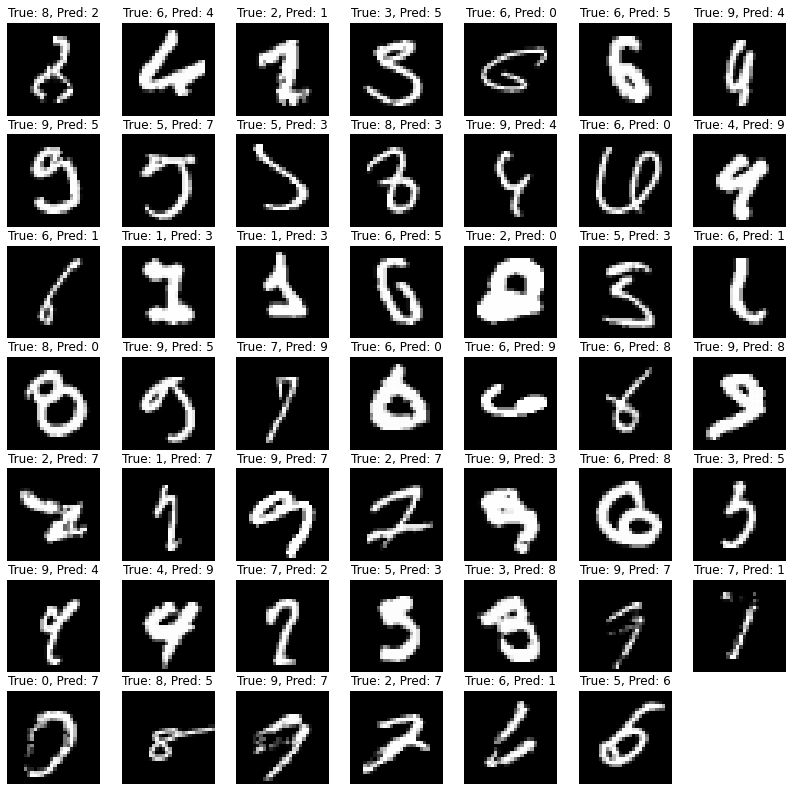

In [18]:
for i in range(result_list[-1]):

    wrong_result = []

    pred_result = result_list[1][i].predict(X_test)
    pred_labels = np.argmax(pred_result, axis = 1)
    test_labels = np.argmax(y_test, axis=1)

    for j in range(0, len(y_test)):
        if pred_labels[j] != test_labels[j]:
            wrong_result.append(j)

    num_wrong = len(wrong_result)
    sqrt_num_wrong = math.ceil(math.sqrt(num_wrong))

    print("In Test #{0}, {1} data were not matched correctly."
    .format(1 + i, num_wrong))

    plt.figure(figsize=(2 * sqrt_num_wrong, 2 * sqrt_num_wrong))

    for k, l in enumerate(wrong_result):

        plt.subplot(sqrt_num_wrong, sqrt_num_wrong, k + 1)
        plt.imshow(tf.squeeze(X_test[l]), cmap = "gray", interpolation="none")
        plt.title("True: {0}, Pred: {1}".format(test_labels[l], pred_labels[l]))
        plt.axis("off")
    
    plt.show()